In [ ]:
!nvcc --version


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


### Installing Colmap with CUDA(T4 GPU)


In [ ]:
# Installing Dependencies
!apt-get update
!apt-get install -y \
    git \
    cmake \
    build-essential \
    libboost-all-dev \
    libfreeimage-dev \
    libgoogle-glog-dev \
    libgflags-dev \
    libglew-dev \
    libsuitesparse-dev \
    libceres-dev \
    libeigen3-dev \
    libflann-dev \
    libcgal-dev \
    libqt5opengl5-dev \
    qtbase5-dev \
    libmetis-dev

!rm -rf /content/colmap
!git clone https://github.com/colmap/colmap.git /content/colmap

%cd /content/colmap
!mkdir -p build
%cd build

# Configure for CUDA support
!cmake .. \
    -DCMAKE_BUILD_TYPE=MinSizeRel \
    -DCUDA_ENABLED=ON \
    -DCUDA_ARCHS="75" \
    -DBUILD_TESTS=OFF \
    -DBUILD_SHARED_LIBS=OFF

# Build and install
!make -j$(nproc)
!sudo make install

# Test
!colmap -h

/content/colmap
/content/colmap/build
-- Enabling LSD support
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found FreeImage
--   Includes : /usr/include
--   Libraries : /usr/lib/x86_64-linux-gnu/libfreeimage.so
-- Found FLANN
--   Includes : /usr/include
--   Libraries : /usr/lib/x86_64-linux-gnu/libflann.so
-- Found LZ4
--   Includes : /usr/include
--   Libraries : /usr/lib/x86_64-linux-gnu/liblz4.so
-- Found Metis
--   Includes : /usr/include
--   Libraries : /usr/lib/x86_64-linux-gnu/libmetis.so
-- Found Glog
--   Target : glog:

In [ ]:
### saving this built for future use() in other notebook use cases
## ZIP file contents

from google.colab import drive
drive.mount('/content/drive')

# Create directory for COLMAP installation
!mkdir -p /content/drive/MyDrive/colmap_install/lib

# Copy the COLMAP binary
!cp /usr/local/bin/colmap /content/drive/MyDrive/colmap_install/

# Copy all COLMAP-related libraries
!cp /usr/local/lib/libcolmap_*.a /content/drive/MyDrive/colmap_install/lib/
!cp /usr/local/lib/libPoseLib.a /content/drive/MyDrive/colmap_install/lib/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Previously compiled COLMAP installation

In [ ]:
def install_colmap():
    import subprocess
    try:
        result = subprocess.run(['colmap', '-h'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        if result.returncode == 0:
            print("COLMAP is already installed")
            return True
    except:
        print("Installing COLMAP...")

    # Create directories if they don't exist
    !sudo mkdir -p /usr/local/bin
    !sudo mkdir -p /usr/local/lib

    # Copy the COLMAP binary
    !sudo cp /content/drive/MyDrive/colmap_install/colmap /usr/local/bin/

    # Copy all COLMAP library files
    !sudo cp /content/drive/MyDrive/colmap_install/lib/* /usr/local/lib/

    # Make the binary executable
    !sudo chmod +x /usr/local/bin/colmap

    # Update the library cache
    !sudo ldconfig

install_colmap()

COLMAP is already installed


True

##download data

In [ ]:
!mkdir -p /content/drive/MyDrive/colmap_data/images
!pip install yt_dlp

In [ ]:
!pip install yt_dlp
!pip install opencv-python

In [ ]:
import cv2
from pathlib import Path
import os
import sys


img_path = Path("/content/drive/MyDrive/colmap_data/images")
img_path.mkdir(parents=True, exist_ok=True)

# Get the video file path
video_file = "/content/drive/MyDrive/colmap_data/video.mp4"

if not os.path.exists(video_file):
    print(f"Video file not found: {video_file}")
    exit()

# Open video file
cap = cv2.VideoCapture(video_file)

frame_no = 0
# total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames = 2400

while cap.isOpened():
    ret, frame = cap.read()

    if not ret or frame is None:
        print(f"\nFrame {frame_no} is unreadable or video ended.")
        break  # Stop if video ends or frame is unreadable

    # Skip the first 159 frames
    if frame_no < 160:
        frame_no += 1
        continue

    if frame_no % 20 == 0:  # Save every 20th frame
        target = str(img_path / f'{frame_no}.jpg')
        cv2.imwrite(target, frame)

    # Display progress bar every 100 frames
    if frame_no % 100 == 0:
        progress = int((frame_no / total_frames) * 50)
        sys.stdout.write(f"\rProgress: [{'#' * progress}{'.' * (50 - progress)}] {frame_no}/{total_frames} frames")
        sys.stdout.flush()

    frame_no += 1

    if frame_no > 60 * 40:
        break

cap.release()
print("\nProcessing complete!")

Progress: [##################################################] 2400/2400 frames
Processing complete!


In [ ]:
import torch
torch.cuda.is_available()


True

In [ ]:
# Copy data from Drive to local storage
!mkdir -p /content/colmap_data
!mkdir -p /content/colmap_data/sparse
!cp -r "/content/drive/MyDrive/colmap_data/images" /content/colmap_data/

IMAGE_PATH = "/content/colmap_data/images"
OUTPUT_PATH = "/content/colmap_data"


## Sparse Reconstruction (SfM)  
###Feature Extraction

detected distinctive points (SIFT features) in each image
These are unique, recognizable points like corners or texture patterns
Each feature has a descriptor that encodes its appearance

In [ ]:
!colmap feature_extractor \
   --database_path $OUTPUT_PATH/database.db \
   --image_path $IMAGE_PATH \
   --SiftExtraction.use_gpu 1



### Step 2: Feature Matching
matched features between images to find correspondences
For your video frames, sequential matching was most efficient
This established which points in different images correspond to the same 3D point

In [ ]:
# As its a video frames data type lets use sequential_matcher
!colmap sequential_matcher \
   --database_path $OUTPUT_PATH/database.db \
   --SiftMatching.use_gpu 1 \
   --SiftMatching.max_num_matches 8192 \
   --SequentialMatching.overlap 20 \
   --SequentialMatching.quadratic_overlap 1

# !colmap exhaustive_matcher \
#    --database_path $OUTPUT_PATH/database.db \
#    --SiftMatching.use_gpu 1 \
#    --SiftMatching.max_num_matches 32768 \
#    --SiftMatching.gpu_index 0



### Step 3: Structure-from-Motion (Sparse Reconstruction)
estimated camera positions and orientations
It triangulated the 3D positions of the matched feature points
It performed bundle adjustment to refine the entire reconstruction

In [ ]:
!colmap mapper \
   --database_path $OUTPUT_PATH/database.db \
   --image_path $IMAGE_PATH \
   --output_path $OUTPUT_PATH/sparse \
   --Mapper.num_threads 2 \
   --Mapper.ba_global_max_num_iterations 15 \
   --Mapper.ba_local_max_num_iterations 10 \
   --Mapper.init_min_num_inliers 15 \
   --Mapper.abs_pose_min_num_inliers 12 \
   --Mapper.filter_max_reproj_error 4.0 \
   --Mapper.filter_min_tri_angle 1.5 \
   --Mapper.multiple_models 0

I0316 19:40:57.384116 27953 incremental_pipeline.cc:251] Loading database
I0316 19:40:57.386557 27953 database_cache.cc:66] Loading cameras...
I0316 19:40:57.386785 27953 database_cache.cc:76]  113 in 0.000s
I0316 19:40:57.386957 27953 database_cache.cc:84] Loading matches...
I0316 19:40:57.403692 27953 database_cache.cc:89]  466 in 0.017s
I0316 19:40:57.407934 27953 database_cache.cc:105] Loading images...
I0316 19:40:57.550125 27953 database_cache.cc:153]  113 in 0.142s (connected 112)
I0316 19:40:57.550184 27953 database_cache.cc:164] Loading pose priors...
I0316 19:40:57.550649 27953 database_cache.cc:175]  0 in 0.000s
I0316 19:40:57.550662 27953 database_cache.cc:184] Building correspondence graph...
I0316 19:40:57.763046 27953 database_cache.cc:210]  in 0.212s (ignored 0)
I0316 19:40:57.763265 27953 timer.cc:91] Elapsed time: 0.006 [minutes]
I0316 19:40:57.776808 27953 incremental_pipeline.cc:297] Finding good initial image pair
I0316 19:40:58.262060 27953 incremental_pipeline.cc

# Dense Reconstruction

###Image undistorter:
 Limits image size to 2000px which is typically sufficient for video frames while maintaining good computational efficiency.

In [ ]:
!mkdir -p $OUTPUT_PATH/dense

# Step 1: Image undistortion
!colmap image_undistorter \
    --image_path $IMAGE_PATH \
    --input_path $OUTPUT_PATH/sparse/0 \
    --output_path $OUTPUT_PATH/dense \
    --max_image_size 2000


I0316 19:50:43.129849 30499 misc.cc:44] 
Reading reconstruction
I0316 19:50:43.360535 30499 image.cc:346] => Reconstruction with 68 images and 28114 points
I0316 19:50:43.360587 30499 misc.cc:44] 
Image undistortion
I0316 19:50:43.361955 30499 undistortion.cc:215] Undistorting image [1/68]
I0316 19:50:44.532717 30499 undistortion.cc:215] Undistorting image [2/68]
I0316 19:50:44.543677 30499 undistortion.cc:215] Undistorting image [3/68]
I0316 19:50:45.298588 30499 undistortion.cc:215] Undistorting image [4/68]
I0316 19:50:45.307735 30499 undistortion.cc:215] Undistorting image [5/68]
I0316 19:50:46.231003 30499 undistortion.cc:215] Undistorting image [6/68]
I0316 19:50:46.231040 30499 undistortion.cc:215] Undistorting image [7/68]
I0316 19:50:47.008661 30499 undistortion.cc:215] Undistorting image [8/68]
I0316 19:50:47.054266 30499 undistortion.cc:215] Undistorting image [9/68]
I0316 19:50:47.726050 30499 undistortion.cc:215] Undistorting image [10/68]
I0316 19:50:47.784924 30499 undis

Dense stereo matching: (creates depth maps for each image )
######Patch match stereo:
> Uses geometric consistency to improve quality

> Limits image size to 1000px to speed up processing

> Uses a smaller window radius (5) and step (2) which works well for video frames
>Reduces iterations to 5 to speed up processing

>Sets GPU index to 0 to utilize the T4 GPU

In [ ]:
!colmap patch_match_stereo \
    --workspace_path $OUTPUT_PATH/dense \
    --workspace_format COLMAP \
    --PatchMatchStereo.geom_consistency true \
    --PatchMatchStereo.gpu_index 0 \
    --PatchMatchStereo.num_iterations 5 \
    --PatchMatchStereo.max_image_size 1000 \
    --PatchMatchStereo.window_radius 5 \
    --PatchMatchStereo.window_step 2 \
    --PatchMatchStereo.num_samples 15 \


Streaming output truncated to the last 5000 lines.
I0316 19:56:01.994213 30637 patch_match.cc:58] 27 
I0316 19:56:01.994220 30637 patch_match.cc:58] 26 
I0316 19:56:01.994222 30637 patch_match.cc:58] 25 
I0316 19:56:01.994227 30637 patch_match.cc:58] 24 
I0316 19:56:01.994231 30637 patch_match.cc:58] 4 
I0316 19:56:01.994235 30637 patch_match.cc:58] 23 
I0316 19:56:01.994240 30637 patch_match.cc:58] 10 
I0316 19:56:01.994246 30637 patch_match.cc:58] 22 
I0316 19:56:01.994252 30637 patch_match.cc:58] 9 
I0316 19:56:01.994256 30637 patch_match.cc:58] 15 
I0316 19:56:01.994262 30637 patch_match.cc:58] 16 
I0316 19:56:01.994266 30637 patch_match.cc:58] 8 
I0316 19:56:01.994271 30637 patch_match.cc:60] 21
I0316 19:56:01.994278 30637 misc.cc:51] 
PatchMatchOptions
-----------------
I0316 19:56:01.994284 30637 patch_match_options.cc:47] max_image_size: 1000
I0316 19:56:01.994292 30637 patch_match_options.cc:48] gpu_index: 0
I0316 19:56:01.994295 30637 patch_match_options.cc:49] depth_min: 2.9

Now lets do Stereo fusion:(combines depth maps into a dense point cloud)

> Checks fewer images (5) which is appropriate for video sequences

>Uses a stricter reprojection error (2.0)
Requires fewer pixels (3) for a point to be valid

In [ ]:
!colmap stereo_fusion \
    --workspace_path $OUTPUT_PATH/dense \
    --workspace_format COLMAP \
    --input_type geometric \
    --output_path $OUTPUT_PATH/dense/fused.ply \
    --StereoFusion.check_num_images 5 \
    --StereoFusion.max_reproj_error 2.0 \
    --StereoFusion.min_num_pixels 3


I0316 20:09:33.880406 35309 misc.cc:51] 
StereoFusion::Options
---------------------
I0316 20:09:33.880482 35309 fusion.cc:76] mask_path: 
I0316 20:09:33.880493 35309 fusion.cc:77] max_image_size: -1
I0316 20:09:33.880501 35309 fusion.cc:78] min_num_pixels: 3
I0316 20:09:33.880506 35309 fusion.cc:79] max_num_pixels: 10000
I0316 20:09:33.880512 35309 fusion.cc:80] max_traversal_depth: 100
I0316 20:09:33.880519 35309 fusion.cc:81] max_reproj_error: 2
I0316 20:09:33.880532 35309 fusion.cc:82] max_depth_error: 0.01
I0316 20:09:33.880548 35309 fusion.cc:83] max_normal_error: 10
I0316 20:09:33.880555 35309 fusion.cc:84] check_num_images: 5
I0316 20:09:33.880563 35309 fusion.cc:85] use_cache: 0
I0316 20:09:33.880569 35309 fusion.cc:86] cache_size: 32
I0316 20:09:33.880576 35309 fusion.cc:89] bbox_min: -3.40282e+38 -3.40282e+38 -3.40282e+38
I0316 20:09:33.880597 35309 fusion.cc:90] bbox_max: 3.40282e+38 3.40282e+38 3.40282e+38
I0316 20:09:33.880614 35309 fusion.cc:140] Reading workspace...
I03

In [ ]:
### result save back to drive
!mkdir -p "/content/drive/MyDrive/colmap_data/dense"
!cp -r $OUTPUT_PATH/dense/ "/content/drive/MyDrive/colmap_data/dense/"

!mkdir -p "/content/drive/MyDrive/colmap_data/sparse"
!cp -r $OUTPUT_PATH/sparse "/content/drive/MyDrive/colmap_data/sparse"

!cp -r $OUTPUT_PATH/database.db "/content/drive/MyDrive/colmap_data/database.db"

# Output in meshlab
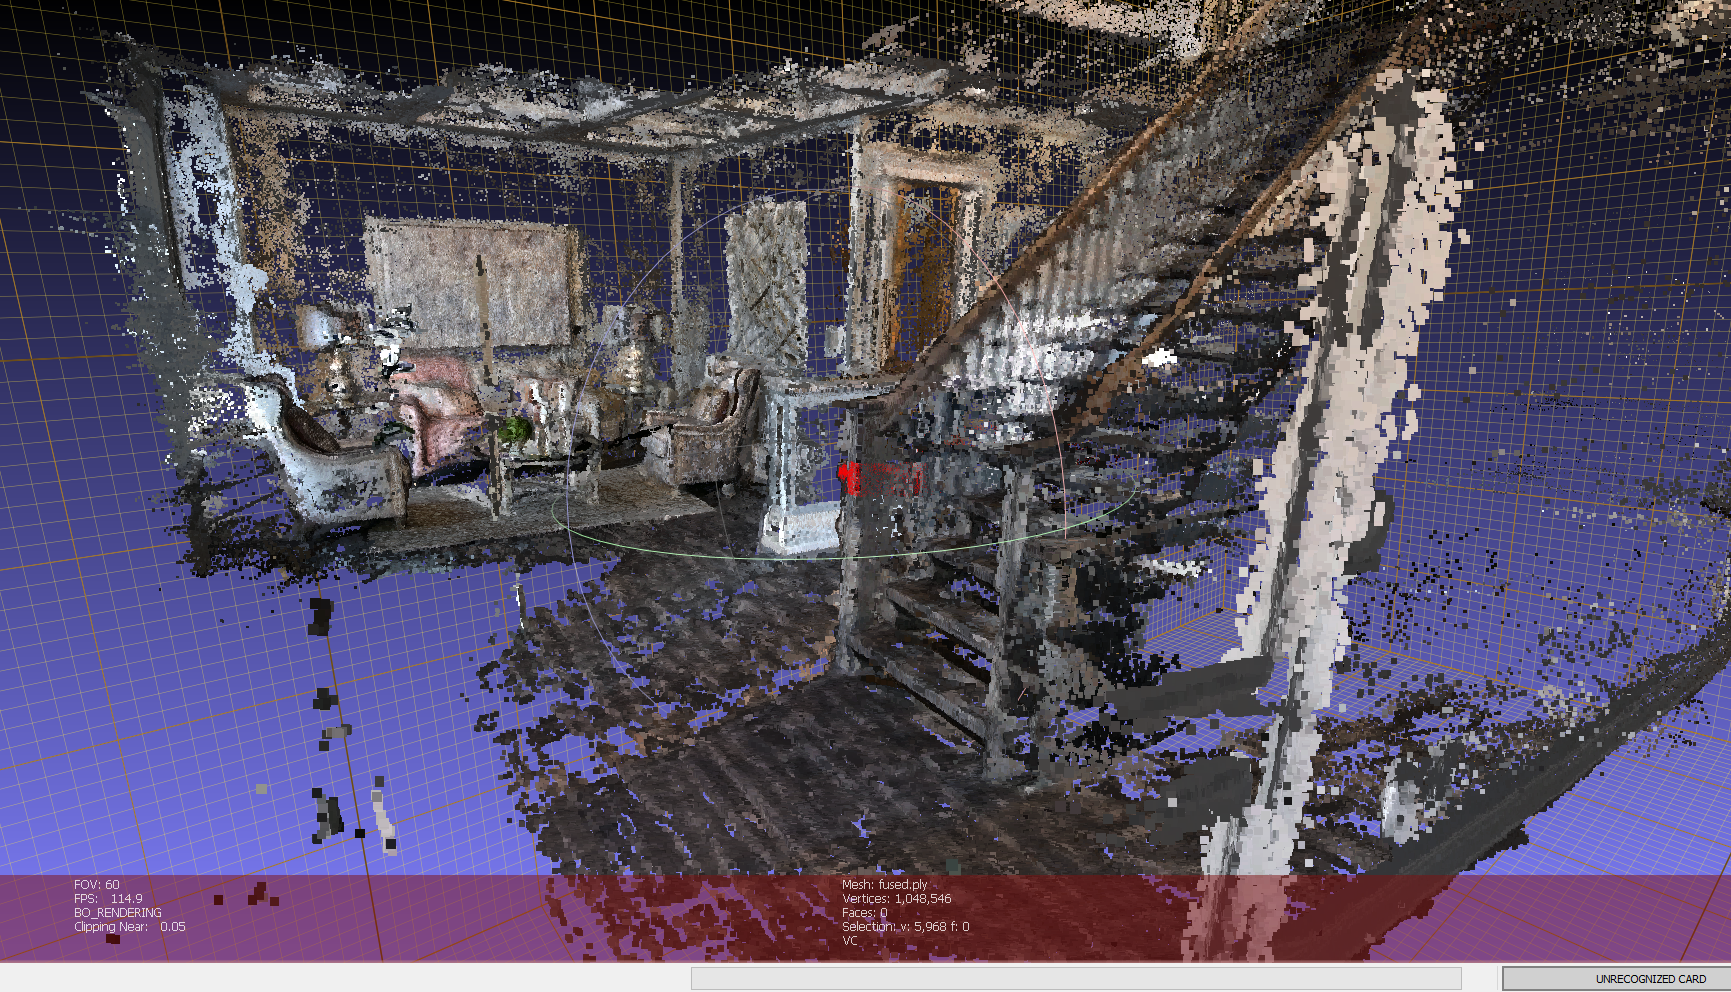

This is a raw mesh!!


to use this for 3D reconstruction, we need to process the point cloud to reduce noise
Applying a surface reconstruction algorithm to generate a continuous mesh
Potentially capturing more data to fill in sparse areas